In [2]:
import pandas as pd
import numpy as np

import sys
import os
current_dir = os.path.dirname(os.path.abspath('__file__'))
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

from dataHandler.preprocessor import Preprocessor
from sklearn import model_selection

__Accesing data__

In [3]:
directory = "/home/michal/Desktop/UniversityOfEssex/MasterProject/22-24_CE901-CE911-CF981-SU_kaczmarczyk_michal_p/data/Bloomberg/"
files = os.listdir(directory)
files = [f for f in files if os.path.isfile(directory+'/'+f)]
files
files = ["RR.L.csv"]

In [4]:
dataDir = "/home/michal/Desktop/UniversityOfEssex/MasterProject/22-24_CE901-CE911-CF981-SU_kaczmarczyk_michal_p/data/data/"
dataset = []
for file in files:
    df = pd.read_csv(dataDir + file).set_index("Date")
    columns = df.columns
    df = df[columns[0:6]]
    df.index = pd.to_datetime(df.index)
    bl = pd.read_csv(directory + file).set_index("Date")
    bl.index = pd.to_datetime(bl.index)
    bl = bl["Price Earnings Ratio \n(P/E) \n(RR/ LN Equity)"]
    bl = bl.resample('D')
    bl = bl.ffill()
    bl = bl.bfill()
    df = df.join(bl, how="inner")
    dataset.append(df)

__Splitting data__

In [5]:
trainDataset = []
testDataset = []
preprocessor = Preprocessor()
i=0
for df in dataset:
    df.insert(0, "Date", df.index)
    df = preprocessor.leaveDataSinceDate(df)
    #if files[i] == "RR.L.csv":
    train, test = model_selection.train_test_split(df, test_size=0.2, shuffle=False)
    trainDataset.append(train)
    testDataset.append(test)
    #else:
    #    trainDataset.append(df)
    i+=1

__Preprocessing data__

In [6]:
preprocessor = Preprocessor()
for i in range(len(trainDataset)):
    trainDataset[i] = preprocessor.dropUnnamedColumn(trainDataset[i])
    trainDataset[i] = preprocessor.dropDuplicates(trainDataset[i])
    trainDataset[i] = preprocessor.addChangeFeature(trainDataset[i])
    columns = trainDataset[i].columns
    trainDataset[i][columns[1:]] = preprocessor.fillMissingData(trainDataset[i][columns[1:]])
    trainDataset[i][columns[1:]] = preprocessor.scaleData(trainDataset[i][columns[1:]])
    trainDataset[i] = preprocessor.sortValuesByDate(trainDataset[i])
    trainDataset[i].set_index("Date", inplace = True)

In [7]:
preprocessor = Preprocessor()
for i in range(len(testDataset)):
    testDataset[i] = preprocessor.dropUnnamedColumn(testDataset[i])
    testDataset[i] = preprocessor.dropDuplicates(testDataset[i])
    testDataset[i] = preprocessor.addChangeFeature(testDataset[i])
    columns = testDataset[i].columns
    testDataset[i][columns[1:]] = preprocessor.fillMissingData(testDataset[i][columns[1:]])
    testDataset[i][columns[1:]] = preprocessor.scaleData(testDataset[i][columns[1:]])
    testDataset[i] = preprocessor.sortValuesByDate(testDataset[i])
    testDataset[i].set_index("Date", inplace = True)

preprocessor.saveScalers()

__Creating training sequences__

In [8]:
def createSequenceForTrend(dataX, dataY, lengthX, predictionHorizont):
    xData = []
    yData = []
    for i in range(len(dataX) - lengthX - predictionHorizont):
        xData.append(dataX[i:i+lengthX].values)

        if(dataY[lengthX+i - 1] <= dataY[lengthX + predictionHorizont + i - 1]):
            yData.append(1.0)
        else:
            yData.append(0.0)
    return xData, yData

features = len(trainDataset[0].iloc[0])
samplesForPrediction = 10
samplesPredicted = 1

trainDates = trainDataset[0].index[samplesForPrediction+1:]
testDates = testDataset[0].index[samplesForPrediction+1:]
xTrain = []
yTrain = []
xTest = []
yTest = []
for df in trainDataset:
    trainX, trainY = createSequenceForTrend(df, df["Close"], samplesForPrediction, samplesPredicted)
    xTrain += trainX
    yTrain += trainY
for df in testDataset:
    testX, testY = createSequenceForTrend(df, df["Close"], samplesForPrediction, samplesPredicted)
    xTest += testX
    yTest += testY

/tmp/ipykernel_8790/1021549121.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(dataY[lengthX+i - 1] <= dataY[lengthX + predictionHorizont + i - 1]):


In [9]:
len(trainDataset[0]["Close"]) - len(yTrain)

11

__Making pyTorch Dataset__

In [10]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, recall_score

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [11]:
xTrain = torch.Tensor(xTrain).to(device)
yTrain = torch.Tensor(yTrain).to(device)
xTest = torch.Tensor(xTest).to(device)
yTest = torch.Tensor(yTest).to(device)

/tmp/ipykernel_8790/1264527518.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  xTrain = torch.Tensor(xTrain).to(device)


In [12]:
loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(xTrain, yTrain), shuffle=False, batch_size=32)

__Model__

In [13]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.l1 = nn.LSTM(input_size = samplesForPrediction*features, hidden_size = 64, num_layers = 1, bidirectional = True, device = device, bias=True)
        self.tanh = nn.Tanh()
        self.out = nn.Linear(128, 1, device = device, bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.flatten(x)
        x, _ = self.l1(x)
        x = self.tanh(x)
        out = self.out(x)
        out = self.sigmoid(out)
        return out

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): LSTM(80, 64, bidirectional=True)
  (tanh): Tanh()
  (out): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [14]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [15]:
def trainLoop(epochs):
    train_loss = []
    test_loss = []
    for epoch in range(epochs):
        model.train()
        for inputData, desired in loader:
            inputData = inputData.to(device)
            desired = desired.to(device).unsqueeze(1)
            pred = model(inputData)

            loss = loss_fn(pred, desired)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        model.eval()
        with torch.no_grad():
            y_pred = model(xTrain.to(device))
            train_loss.append(loss_fn(y_pred, yTrain.unsqueeze(1)).cpu().numpy().tolist())
            y_pred = model(xTest.to(device))
            test_loss.append(loss_fn(y_pred, yTest.unsqueeze(1)).cpu().numpy().tolist())
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss[-1:]}, Test Loss: {test_loss[-1:]}')
    return train_loss, test_loss


#model = torch.load('model.pth')
train_loss, test_loss = trainLoop(75)
#torch.save(model, 'model.pth')

#300Epochs

Epoch [1/75], Train Loss: [0.6942821145057678], Test Loss: [0.6931833624839783]
Epoch [2/75], Train Loss: [0.6927824020385742], Test Loss: [0.6931016445159912]
Epoch [3/75], Train Loss: [0.6925613880157471], Test Loss: [0.6933810114860535]
Epoch [4/75], Train Loss: [0.6923344731330872], Test Loss: [0.6933900117874146]
Epoch [5/75], Train Loss: [0.6919680833816528], Test Loss: [0.6932575106620789]
Epoch [6/75], Train Loss: [0.6911832690238953], Test Loss: [0.6926496028900146]
Epoch [7/75], Train Loss: [0.6873454451560974], Test Loss: [0.6886279582977295]
Epoch [8/75], Train Loss: [0.6888996362686157], Test Loss: [0.6888713240623474]
Epoch [9/75], Train Loss: [0.6830111145973206], Test Loss: [0.6891372203826904]
Epoch [10/75], Train Loss: [0.6729479432106018], Test Loss: [0.6791573166847229]
Epoch [11/75], Train Loss: [0.6633379459381104], Test Loss: [0.6576972603797913]
Epoch [12/75], Train Loss: [0.6618235111236572], Test Loss: [0.6451907157897949]
Epoch [13/75], Train Loss: [0.6369841

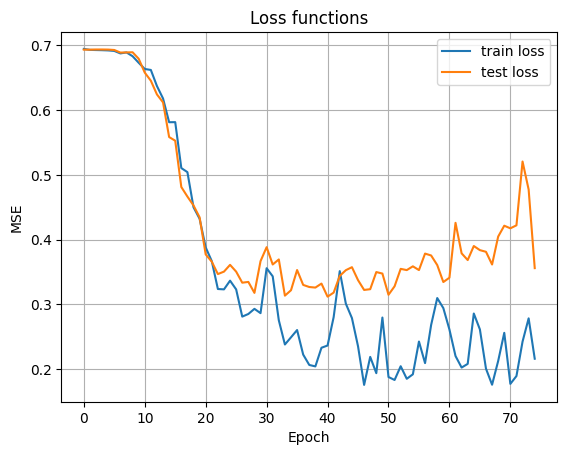

In [16]:
fig, ax = plt.subplots()
ax.plot(train_loss)
ax.plot(test_loss)
ax.legend(["train loss", "test loss"])
ax.grid()
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.title("Loss functions")
plt.show()

__Testing__

In [17]:
# Make predictions
y_pred = model(xTrain).cpu()
y_pred = y_pred.detach().numpy()

y_pred = y_pred.round()

# Calculate the mean squared error across all outputs
accuracy = accuracy_score(yTrain.cpu().detach().numpy(), y_pred)
print(f'Accuracy_score: {accuracy}')
recall = recall_score(yTrain.cpu().detach().numpy(), y_pred)
print(f'Recall_score: {recall}')

Accuracy_score: 0.9071285140562249
Recall_score: 0.8964467005076142


In [18]:
# Make predictions
y_pred = model(xTest).cpu()
y_pred = y_pred.detach().numpy()

y_pred = y_pred.round()

# Calculate the mean squared error across all outputs
accuracy = accuracy_score(yTest.cpu().detach().numpy(), y_pred)
print(f'Accuracy_score: {accuracy}')
recall = recall_score(yTest.cpu().detach().numpy(), y_pred)
print(f'Recall_score: {recall}')


Accuracy_score: 0.8877551020408163
Recall_score: 0.8539325842696629


__Profit Calculation__

In [19]:
#Rescaling
dummyDataset = testDataset[0]
dummyDataset["Close"] = testDataset[0]['Close']
dummyDataset = preprocessor.scaler.inverse_transform(dummyDataset)
real = dummyDataset[:,3]

In [20]:
#real = np.concatenate(yTrain.cpu().detach().numpy()[::1])
profit = 0
lastBuy = 0
action = []

#real = testDataset[0]['Close'].values

for realVal, predVal in zip(real[samplesForPrediction::samplesPredicted], y_pred[samplesPredicted::samplesPredicted]):
    if(predVal==1 and lastBuy == 0):
        lastBuy = realVal
        action.append(1)
    elif(predVal==0 and lastBuy > 0):
        profit += realVal - lastBuy
        lastBuy = 0
        action.append(-1)
    else:
        action.append(0)

if(lastBuy>0):
    profit += realVal - lastBuy
    lastBuy = 0
    action.append(-1)
else:
    action.append(0)

print(profit)

870.5900450000003


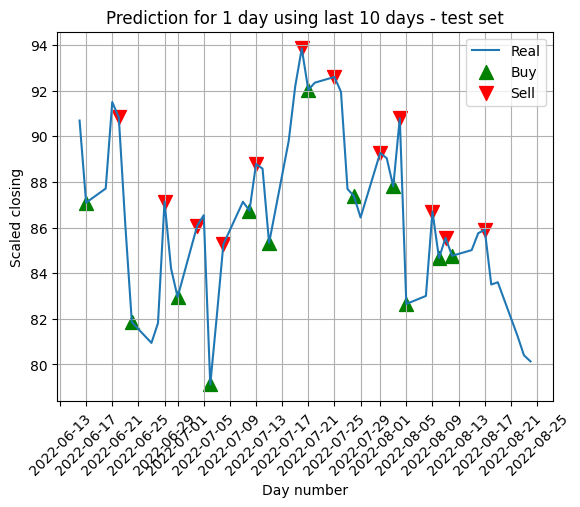

In [26]:
real2 = real[samplesForPrediction:-1]
testDatesP = testDates[:]
action = np.array(action[:])

buy_dates = np.array(testDatesP)[action == 1]
sell_dates = np.array(testDatesP)[action == -1]

buy_prices = real2[action == 1]
sell_prices = real2[action == -1]

fig, ax = plt.subplots()
ax.plot(np.array(testDatesP[:50]), real2[:50], zorder = 3)

ax.scatter(buy_dates[:12], buy_prices[:12], color='green', marker='^', s=100, label='Buy')
ax.scatter(sell_dates[:12], sell_prices[:12], color='red', marker='v', s=100, label='Sell')

# Rotate date labels for better readability
plt.xticks(rotation=45)

# Optionally, set the locator to have fewer ticks
locator = plt.matplotlib.dates.AutoDateLocator(minticks=10, maxticks=20)
ax.xaxis.set_major_locator(locator)

ax.legend(["Real", "Buy", "Sell"])
ax.grid()
plt.ylabel("Scaled closing")
plt.xlabel("Day number")
plt.title("Prediction for 1 day using last 10 days - test set")
plt.show()

